<a href="https://colab.research.google.com/github/finlytics-hub/ODI/blob/master/Cricket_ODI_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Environment Setup](#scrollTo=TLtrrWI5r513)

>[Data Collection](#scrollTo=l3txS8S5r518)

>>>[Web scraping for toss information](#scrollTo=_mmFlArrr52W)

>[Data Munging and Some More Web Scraping](#scrollTo=fCNW5h7Er52g)

>>>[ODI_results DF](#scrollTo=DafjW3S7r52g)

>>>[ODI_innings DF](#scrollTo=XxCgOTx9r52j)

>>>[Merge ODI_results and ODI_innings](#scrollTo=9WV1IKOOr52o)

>>>[Scraping for ICC ODI Batting and Bowling Ranks](#scrollTo=vT_LtCDur53L)

>>>[toss_df](#scrollTo=NI4f_CTxr53a)

>[Feature Engineering](#scrollTo=kGJNO0GSr53o)

>>>[Match Month](#scrollTo=dUwPsUpbr53o)

>>>[Win/Loss Ratio](#scrollTo=4oBFnn3Or53r)

>>>[Batting/Bowling Averages and RPO](#scrollTo=qFNThJsNr53t)

>>>[Toss Won By](#scrollTo=BDEt0g2ur535)

>>>[Player Rankings](#scrollTo=5GI-vkXr17ZF)

>[Feature Selection](#scrollTo=j9ij-eUGr539)

>>>[Categorical Feature Selection - Chi Squared Test](#scrollTo=HkEB-ZutfRI-)

>>>[Numerical Feature Selection - F-Statistic](#scrollTo=QrmIR4nzhu1D)

>[Model Training & Validation](#scrollTo=3qt171DkVrCy)



# Environment Setup

In [ ]:
# import all the required libraries

# for web scraping
from bs4 import BeautifulSoup
import requests

# for core data manipulation and analysis
import pandas as pd
import numpy as np
import datetime as dt

# for plotting
import matplotlib.pyplot as plt

# for feature selection, model training and evaluation
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# to save final model
import pickle

# Data Collection

Our main data source will be the 2 datasets publicly available [here](https://data.world/cclayford/cricinfo-statsguru-data). This data was scrapped from [Cricinfo's Statsguru](https://stats.espncricinfo.com/ci/engine/stats/index.html). We will use the following 4 files available here:
- [Men ODI Team Match Results - 20th Century.csv](https://data.world/cclayford/cricinfo-statsguru-data/file/Men%20ODI%20Team%20Match%20Results%20-%2020th%20Century.csv)
- [Men ODI Team Match Results - 21st Century.csv](https://data.world/cclayford/cricinfo-statsguru-data/file/Men%20ODI%20Team%20Match%20Results%20-%2021st%20Century.csv)
- [Men ODI Player Innings Stats - 20th Century.csv](https://data.world/cclayford/cricinfo-statsguru-data/file/Men%20ODI%20Player%20Innings%20Stats%20-%2020th%20Century.csv)
- [Men ODI Player Innings Stats - 21st Century.csv](https://data.world/cclayford/cricinfo-statsguru-data/file/Men%20ODI%20Player%20Innings%20Stats%20-%2021st%20Century.csv)

The 1st 2 files above have all the relevant match details (including names of the playing teams, match date, ground and result). While the last 2 files include the player names in each match together with their batting and bowling figures.

Despite the rich information available in these 4 files, they are still missing some other critical information as follows:
- toss result
- ICC Player ranks

We will perform web scraping to get the above bits of information.

In [ ]:
# load the 4 files in respective DFs
results_20thC = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/Raw data/Men ODI Team Match Results - 20th Century.csv')
results_21stC = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/Raw data/Men ODI Team Match Results - 21st Century.csv')
innings_20thC = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/Raw data/Men ODI Player Innings Stats - 20th Century.csv')
innings_21stC = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/Raw data/Men ODI Player Innings Stats - 21st Century.csv')

Explore and confirm that each of the 2 related files do in fact have the same information and columns before concatenating them

In [ ]:
results_20thC.head()

,Result,Margin,Match,Home/Away,Ground,Match Date,Match Month,Match Year,Match Period,Matches,Country
0,Lost,5 wickets,Australia v England,Away,Melbourne,1971/01/05,Jan,1971,Jan 1971,1,England
1,Won,6 wickets,England v Australia,Home,Manchester,1972/08/24,Aug,1972,Aug 1972,1,England
2,Lost,5 wickets,England v Australia,Home,Lord's,1972/08/26,Aug,1972,Aug 1972,1,England
3,Won,2 wickets,England v Australia,Home,Birmingham,1972/08/28,Aug,1972,Aug 1972,1,England
4,Won,7 wickets,England v New Zealand,Home,Swansea,1973/07/18,Jul,1973,Jul 1973,1,England


In [ ]:
results_21stC.head()

,Result,Margin,Match,Home/Away,Ground,Match Date,Match Month,Match Year,Match Period,Matches,Country
0,Lost,5 wickets,Sri Lanka v England,Away,Dambulla,2001/03/23,Mar,2001,Mar 2001,1,England
1,Lost,66 runs,Sri Lanka v England,Away,Colombo (RPS),2001/03/25,Mar,2001,Mar 2001,1,England
2,Lost,10 wickets,Sri Lanka v England,Away,Colombo (SSC),2001/03/27,Mar,2001,Mar 2001,1,England
3,Lost,108 runs,England v Pakistan,Home,Birmingham,2001/06/07,Jun,2001,Jun 2001,1,England
4,Lost,5 wickets,England v Australia,Home,Bristol,2001/06/10,Jun,2001,Jun 2001,1,England


In [ ]:
innings_20thC.head()

,Innings Player,Innings Runs Scored,Innings Runs Scored Num,Innings Minutes Batted,Innings Batted Flag,Innings Not Out Flag,Innings Balls Faced,Innings Boundary Fours,Innings Boundary Sixes,Innings Batting Strike Rate,...,Innings Overs Bowled,Innings Bowled Flag,Innings Maidens Bowled,Innings Runs Conceded,Innings Wickets Taken,4 Wickets,5 Wickets,10 Wickets,Innings Wickets Taken Buckets,Innings Economy Rate
0,RA Smith,167*,167,208,1.0,1.0,163,17,3,102.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DI Gower,158,158,177,1.0,0.0,118,18,4,133.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CWJ Athey,142*,142,208,1.0,1.0,172,14,0,82.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GA Gooch,142,142,-,1.0,0.0,134,14,0,105.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DL Amiss,137,137,-,1.0,0.0,147,18,0,93.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
innings_21stC.head()

,Innings Player,Innings Runs Scored,Innings Runs Scored Num,Innings Minutes Batted,Innings Batted Flag,Innings Not Out Flag,Innings Balls Faced,Innings Boundary Fours,Innings Boundary Sixes,Innings Batting Strike Rate,...,Innings Overs Bowled,Innings Bowled Flag,Innings Maidens Bowled,Innings Runs Conceded,Innings Wickets Taken,4 Wickets,5 Wickets,10 Wickets,Innings Wickets Taken Buckets,Innings Economy Rate
0,JJ Roy,180,180,151,1.0,0.0,151,16,5,119.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AD Hales,171,171,166,1.0,0.0,122,22,4,140.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JJ Roy,162,162,172,1.0,0.0,118,13,3,137.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AJ Strauss,158,158,188,1.0,0.0,145,18,1,108.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AJ Strauss,154,154,201,1.0,0.0,140,16,5,110.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
'''looks all good, so let's proceed with concatenating each of the 2 related files together
the one issue I see right now is that both sets of information have information presented in different formats: while the results data have each match in a single row, a single match's information in the innings data spans multiple rows - we will tackle this later on'''
ODI_results = pd.concat([results_20thC, results_21stC], ignore_index = True)
ODI_innings = pd.concat([innings_20thC, innings_21stC], ignore_index = True)

In [ ]:
ODI_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8541 entries, 0 to 8540
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Result        8541 non-null   object
 1   Margin        8522 non-null   object
 2   Match         8541 non-null   object
 3   Home/Away     8541 non-null   object
 4   Ground        8541 non-null   object
 5   Match Date    8541 non-null   object
 6   Match Month   8541 non-null   object
 7   Match Year    8541 non-null   int64 
 8   Match Period  8541 non-null   object
 9   Matches       8541 non-null   int64 
 10  Country       8541 non-null   object
dtypes: int64(2), object(9)
memory usage: 734.1+ KB


In [ ]:
ODI_innings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400170 entries, 0 to 400169
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Innings Player                 400170 non-null  object 
 1   Innings Runs Scored            200085 non-null  object 
 2   Innings Runs Scored Num        200085 non-null  object 
 3   Innings Minutes Batted         200085 non-null  object 
 4   Innings Batted Flag            200085 non-null  float64
 5   Innings Not Out Flag           200085 non-null  float64
 6   Innings Balls Faced            200085 non-null  object 
 7   Innings Boundary Fours         200085 non-null  object 
 8   Innings Boundary Sixes         200085 non-null  object 
 9   Innings Batting Strike Rate    200085 non-null  object 
 10  Innings Number                 400170 non-null  object 
 11  Opposition                     400170 non-null  object 
 12  Ground                        

### Web scraping for toss information

Next up, we will scrape the [Howstat website](http://howstat.com/cricket/home.asp) for each ODI's toss information. Each ODI on Howstat has a unique Match Code in that match's URL. Refer [this](http://www.howstat.com/cricket/Statistics/Matches/MatchScorecard_ODI.asp?MatchCode=1000&Print=Y) for an illustration. We will use these unique match codes in a for loop to scrape the following information for every ODI ever played:
- team names
- which team won the toss
- match date
- ground

The reason we're scraping Howstat instead of Cricinfo is because the it is much more easier and straighforward to scrape from Howstat's printable scorecard compared to Cricinfo's scorecards.

Through a bit of trial and error, I was able to find the first match on Howstat (which for some reason is not of the 1st ODI played back in 1971) and copied them in a CSV file. This same trial and error also revealed that not all unique integers starting from the first match code are actually on Howstat. Anyways, the match codes CSV is a cleaned version with only those codes for which match information is available (spanning from 1971 to Mar 2020 - when all international cricket was put on hold due to COVID-19)

In [ ]:
# load match codes from the CSV ensuring that they are loaded as an object datatype and not numeric
match_codes = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/Raw data/match_codes.csv', header = None, dtype = 'object')

# convert the DF to a list
match_codes_list = match_codes.iloc[:, 0].tolist()

In [ ]:
# define an empty dictionary to hold the scrapped data for each match code
toss_dict = {}

# initialize a for loop to go through each match code in the list, scrape the above information from the respective URL, and append to the dictionary
for code in match_codes_list:
    # append match code to the match_code list
    toss_dict.setdefault('Match Code', []).append(code)
    # main URL from which to scrape data
    URL = f'http://www.howstat.com/cricket/Statistics/Matches/MatchScorecard_ODI.asp?MatchCode={code}&Print=Y'
    # request page contents
    page = requests.get(URL)
    # parse the HTML page
    soup = BeautifulSoup(page.content, 'html.parser')
    # get the playing team names (not clean though)
    match_elems = soup.find_all('td', class_ = 'ScoreCardBanner2')
    # append team names to the match list
    toss_dict.setdefault('Match', []).append(match_elems[0].text.strip())
    # find the other required information
    table_data = soup.find_all('td')
    for element in table_data:
        # find match date and append to the corresponding list
        if 'Match Date' in element.get_text():
            date = element.find_next('td').text.strip()
        # find name of the team which won the toss  and append to the corresponding list
        if 'Toss' in element.get_text():
            match_toss = element.find_next('td').text.strip()
        # find ground name and append to the corresponding list
        if 'Venue' in element.get_text():
            match_venue = element.find_next('td').text.strip()
    toss_dict.setdefault('Match Date', []).append(date)
    toss_dict.setdefault('Toss Won By', []).append(match_toss)
    toss_dict.setdefault('Ground', []).append(match_venue)
toss_df = pd.DataFrame(toss_dict)
toss_df.head()

,Match Code,Match,Match Date,Toss Won By,Ground
0,0032,2003-2004 TVS Cup - 8th ODI - India v Australi...,"12th November, 2003",Australia,"M Chinnaswamy Stadium, Bengaluru, Bangalore"
1,0033,2002-2003 Morocco Cup - 3rd ODI - South Africa...,"15th August, 2002",Sri Lanka,"National Cricket Stadium, Tangier"
2,0034,1999 ICC World Cup - 20th ODI - Kenya v South ...,"26th May, 1999",South Africa,"VRA Ground, Amstelveen"
3,0035,1983-1984 Benson & Hedges World Series Cup - 4...,"14th January, 1984",Pakistan,"Brisbane Cricket Ground, Brisbane"
4,0036,1996 England v India - 3rd ODI - \r\n\t\t\t\t...,"26th May, 1996",India,"Old Trafford, Manchester"


In [ ]:
# well that loop sure took a long time to execute. Let's save it in a CSV file so that we don't have to redo it
toss_df.to_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/toss_df.csv', index = False)

In [ ]:
# toss_df = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/toss_df.csv')

Other than ICC Players' ranking information, We now have collected all the raw data required for our project.

Next, we will perform some data cleaning tasks and then some more web scraping to obtain tha players' ICC ranks

 # Data Munging and Some More Web Scraping

### ODI_results DF

Let's clean the ODI_results DF first. Take note of its structure: each match has two records: one from each of the playing team's perspectives. So for example, if England won a match against Australia on a particular day, then this match will have the following 2 records:
- 1 from England's perspective showing that England won this match, and
-  another from Australia's perspective with Australia losing the match

Also note that the DF does not have the Opposition country's name as a separate column, instead it is bundled up with the `Match` column like this: Team 1 v Team 2


In [ ]:
ODI_results_clean = ODI_results.copy()
# split Match column into two separate columns
ODI_results_clean[['Country 1', 'Country 2']] = ODI_results_clean['Match'].str.split('v', expand = True)
# strip out all the leading and trailing whitespaces
ODI_results_clean['Country 1'] = ODI_results_clean['Country 1'].str.strip()
ODI_results_clean['Country 2'] = ODI_results_clean['Country 2'].str.strip()
# create the Opposition column using information from the 2 newly created columns
ODI_results_clean['Opposition'] = np.where(ODI_results_clean['Country 1'] == ODI_results_clean['Country'], ODI_results_clean['Country 2'], ODI_results_clean['Country 1'])
# drop the 2 new columns together with other unwanted columns
ODI_results_clean.drop(columns = ['Margin', 'Match', 'Match Month', 'Match Year', 'Match Period', 'Matches', 'Country 1', 'Country 2'], inplace = True)
# filter out any match results other than 'Won' or 'Lost' so as not to consider matches not played, tied and with no result in our modeling
ODI_results_clean = ODI_results_clean[ODI_results_clean['Result'].isin(['Won', 'Lost'])]
# convert the Match Date column to a datetime format
ODI_results_clean['Match Date'] = pd.to_datetime(ODI_results_clean['Match Date'])
# sort by Match Date
ODI_results_clean.sort_values(by = 'Match Date', inplace = True, ignore_index = True)
ODI_results_clean.head()

,Result,Home/Away,Ground,Match Date,Country,Opposition
0,Lost,Away,Melbourne,1971-01-05,England,Australia
1,Won,Home,Melbourne,1971-01-05,Australia,England
2,Won,Home,Manchester,1972-08-24,England,Australia
3,Lost,Away,Manchester,1972-08-24,Australia,England
4,Lost,Home,Lord's,1972-08-26,England,Australia


### ODI_innings DF

Now we will tackle our ODI_innings DF which requires lot more cleaning to do. Let's first understand its structure:
- Names of every player who played a match are in rows
- The match specific statistics of each player are in columns 
- Both batting and bowling statistics have their own specific columns
- Since a player can both bat and bowl in the same match, therefore, each of the 11 players from the same team are included twice for each match - first with his batting statistics and then his bowling statistics. These two sets are differentiated by the `Innings Number` column

Some issues that I noticed during manual EDA:
- duplicate records for some specific matches where the same innings' statistics are repeated
- in a couple of instances, the players names were duplicated so that the statistics were of two different players but with the same player name. This means we cannot perform a blanket `drop_duplicates` operation. Instead, we will need to select a subset of columns to identify duplicates
- we will also need to modify some spellings in order to match the spellings with that in the official [ICC Rankings](http://www.relianceiccrankings.com/datespecific/odi/) listing
- since the ICC regulations allow the use of substitute players during a match under specific conditions, some of the matches have 12 players' info (instead of the standard 11). we will retain all 12 players' info at this stage and deal with it later

In [ ]:
ODI_innings_clean = ODI_innings.copy()
# drop duplicate records based on a subset of columns only
ODI_innings_clean.drop_duplicates(subset = ['Innings Player', 'Country', 'Opposition', 'Innings Date', 'Ground'], inplace = True)
# drop all the unwanted columns
col_to_drop = ODI_innings_clean.iloc[:, np.r_[1:11, 15:28]].columns.values
ODI_innings_clean.drop(columns = col_to_drop, inplace = True)
# remove 'v' from the Opposition columns
ODI_innings_clean['Opposition'] = ODI_innings_clean['Opposition'].str.replace('v', '')
# rename certain columns
ODI_innings_clean.rename(columns = {'Innings Date': 'Match Date', 'Innings Player': 'Players'}, inplace = True)
# convert the Match Date column to a datetime format
ODI_innings_clean['Match Date'] = pd.to_datetime(ODI_innings_clean['Match Date'])
# sort by Match Date
ODI_innings_clean.sort_values(by = 'Match Date', inplace = True, ignore_index = True)
ODI_innings_clean.head()

,Players,Opposition,Ground,Match Date,Country
0,AL Thomson,England,Melbourne,1971-01-05,Australia
1,AA Mallett,England,Melbourne,1971-01-05,Australia
2,IR Redpath,England,Melbourne,1971-01-05,Australia
3,JH Edrich,Australia,Melbourne,1971-01-05,England
4,IM Chappell,England,Melbourne,1971-01-05,Australia


### Merge ODI_results and ODI_innings

In [ ]:
# first merge the 2 on Country level to get Country's players merged with ODI_results_clean. note the use of 'left' join here and not an 'inner' join as we want to retain all the results information from the 'left' DF even if the corresponding team's players information is not available
ODI_country_players = pd.merge(ODI_results_clean, ODI_innings_clean, how = 'left', left_on = ['Match Date', 'Ground', 'Country'], right_on = ['Match Date', 'Ground', 'Country']).drop(columns = ['Opposition_y'])
# rename columns
ODI_country_players.rename(columns = {'Players': 'Country Players', 'Opposition_x': 'Opposition'}, inplace = True)
ODI_country_players.head()

,Result,Home/Away,Ground,Match Date,Country,Opposition,Country Players
0,Lost,Away,Melbourne,1971-01-05,England,Australia,JH Edrich
1,Lost,Away,Melbourne,1971-01-05,England,Australia,JH Hampshire
2,Lost,Away,Melbourne,1971-01-05,England,Australia,R Illingworth
3,Lost,Away,Melbourne,1971-01-05,England,Australia,MC Cowdrey
4,Lost,Away,Melbourne,1971-01-05,England,Australia,APE Knott


In [ ]:
# next merge on the Opposition columns to get the names of the Opposition players
ODI_opposition_players = pd.merge(ODI_results_clean, ODI_innings_clean, how = 'left', left_on = ['Match Date', 'Ground', 'Opposition'], right_on = ['Match Date', 'Ground', 'Country']).drop(columns = ['Country_y', 'Opposition_y'])
# rename columns
ODI_opposition_players.rename(columns = {'Players': 'Opposition Players', 'Country_x': 'Country', 'Opposition_x': 'Opposition'}, inplace = True)
ODI_opposition_players.head()

,Result,Home/Away,Ground,Match Date,Country,Opposition,Opposition Players
0,Lost,Away,Melbourne,1971-01-05,England,Australia,AL Thomson
1,Lost,Away,Melbourne,1971-01-05,England,Australia,AA Mallett
2,Lost,Away,Melbourne,1971-01-05,England,Australia,IR Redpath
3,Lost,Away,Melbourne,1971-01-05,England,Australia,IM Chappell
4,Lost,Away,Melbourne,1971-01-05,England,Australia,WM Lawry


Now we want to merge the 2 new DFs to have a single DF with all the result and players information together. However, we cannot do it in their current shape without duplicating player's names during the merge process. What we want to have is basically a flat DF structure where each country's match data is in a single row, i.e. all the players are in columns, before applying the merge operation

In [ ]:
# define a function to change (or unstack) our DFs
def df_unstack(df, players_col, col_name):
    grouped = df.groupby(by = ['Match Date', 'Country', 'Opposition', 'Ground', 'Home/Away', 'Result'])
    df_flat = grouped[players_col].apply(lambda x: pd.Series(x.values)).unstack().reset_index()
    df_flat.rename(columns = {i: col_name + '_{}'.format(i + 1) for i in range(df_flat.shape[1])}, inplace = True)
    return df_flat

# apply the function to the 2 DFs
ODI_country_players_flat = df_unstack(ODI_country_players, 'Country Players', 'Country_Player')
ODI_opposition_players_flat = df_unstack(ODI_opposition_players, 'Opposition Players', 'Opposition_Player')

Have a look at the 2 new DFs

In [ ]:
ODI_country_players_flat.tail()

,Match Date,Country,Opposition,Ground,Home/Away,Result,Country_Player_1,Country_Player_2,Country_Player_3,Country_Player_4,Country_Player_5,Country_Player_6,Country_Player_7,Country_Player_8,Country_Player_9,Country_Player_10,Country_Player_11,Country_Player_12
7902,2020-03-06,Zimbabwe,Bangladesh,Sylhet,Away,Lost,TS Kamunhukamwe,Sikandar Raza,CT Mumba,DT Tiripano,BRM Taylor,W Madhevere,CK Tshuma,R Mutumbami,CT Mutombodzi,RW Chakabva,SC Williams,NaN
7903,2020-03-07,Australia,South Africa,Potchefstroom,Away,Lost,M Labuschagne,KW Richardson,AT Carey,JA Richardson,AJ Finch,DJM Short,JR Hazlewood,MR Marsh,A Zampa,SPD Smith,DA Warner,NaN
7904,2020-03-07,South Africa,Australia,Potchefstroom,Home,Won,A Nortje,H Klaasen,Q de Kock,DM Dupavillon,JT Smuts,L Sipamla,JN Malan,KA Maharaj,AL Phehlukwayo,DA Miller,K Verreynne,NaN
7905,2020-03-13,Australia,New Zealand,Sydney,Home,Won,MR Marsh,AT Carey,PJ Cummins,SPD Smith,DA Warner,A Zampa,M Labuschagne,MA Starc,JR Hazlewood,DJM Short,AJ Finch,NaN
7906,2020-03-13,New Zealand,Australia,Sydney,Away,Lost,MJ Santner,KS Williamson,MJ Guptill,TWM Latham,LH Ferguson,JDS Neesham,C de Grandhomme,TA Boult,LRPL Taylor,HM Nicholls,IS Sodhi,NaN


In [ ]:
ODI_country_players_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Match Date         7907 non-null   datetime64[ns]
 1   Country            7907 non-null   object        
 2   Opposition         7907 non-null   object        
 3   Ground             7907 non-null   object        
 4   Home/Away          7907 non-null   object        
 5   Result             7907 non-null   object        
 6   Country_Player_1   7898 non-null   object        
 7   Country_Player_2   7898 non-null   object        
 8   Country_Player_3   7898 non-null   object        
 9   Country_Player_4   7898 non-null   object        
 10  Country_Player_5   7898 non-null   object        
 11  Country_Player_6   7898 non-null   object        
 12  Country_Player_7   7898 non-null   object        
 13  Country_Player_8   7898 non-null   object        
 14  Country_

In [ ]:
ODI_opposition_players_flat.tail()

,Match Date,Country,Opposition,Ground,Home/Away,Result,Opposition_Player_1,Opposition_Player_2,Opposition_Player_3,Opposition_Player_4,Opposition_Player_5,Opposition_Player_6,Opposition_Player_7,Opposition_Player_8,Opposition_Player_9,Opposition_Player_10,Opposition_Player_11,Opposition_Player_12
7902,2020-03-06,Zimbabwe,Bangladesh,Sylhet,Away,Lost,Mahmudullah,Tamim Iqbal,Liton Das,Afif Hossain,Mustafizur Rahman,Mohammad Saifuddin,Taijul Islam,Mohammad Naim,Mohammad Mithun,Mehidy Hasan Miraz,Mashrafe Mortaza,NaN
7903,2020-03-07,Australia,South Africa,Potchefstroom,Away,Lost,A Nortje,H Klaasen,Q de Kock,DM Dupavillon,JT Smuts,L Sipamla,JN Malan,KA Maharaj,AL Phehlukwayo,DA Miller,K Verreynne,NaN
7904,2020-03-07,South Africa,Australia,Potchefstroom,Home,Won,M Labuschagne,KW Richardson,AT Carey,JA Richardson,AJ Finch,DJM Short,JR Hazlewood,MR Marsh,A Zampa,SPD Smith,DA Warner,NaN
7905,2020-03-13,Australia,New Zealand,Sydney,Home,Won,MJ Santner,KS Williamson,MJ Guptill,TWM Latham,LH Ferguson,JDS Neesham,C de Grandhomme,TA Boult,LRPL Taylor,HM Nicholls,IS Sodhi,NaN
7906,2020-03-13,New Zealand,Australia,Sydney,Away,Lost,MR Marsh,AT Carey,PJ Cummins,SPD Smith,DA Warner,A Zampa,M Labuschagne,MA Starc,JR Hazlewood,DJM Short,AJ Finch,NaN


In [ ]:
ODI_opposition_players_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Match Date            7907 non-null   datetime64[ns]
 1   Country               7907 non-null   object        
 2   Opposition            7907 non-null   object        
 3   Ground                7907 non-null   object        
 4   Home/Away             7907 non-null   object        
 5   Result                7907 non-null   object        
 6   Opposition_Player_1   7738 non-null   object        
 7   Opposition_Player_2   7738 non-null   object        
 8   Opposition_Player_3   7738 non-null   object        
 9   Opposition_Player_4   7738 non-null   object        
 10  Opposition_Player_5   7738 non-null   object        
 11  Opposition_Player_6   7738 non-null   object        
 12  Opposition_Player_7   7738 non-null   object        
 13  Opposition_Player_

We can see that both the new flat DFs have certain NULL values in the main 11 player columns (null values in `x_Player_12` column does not concern us at this stage given that we know it was expected). So we will drop rows with null values in the `x_Player_1` columns of both DF

In [ ]:
# drop records with no players information
ODI_country_players_flat.dropna(subset = ['Country_Player_1'], inplace = True)
ODI_opposition_players_flat.dropna(subset = ['Opposition_Player_1'], inplace = True)

Now we can perform the merge operation. notice the use of 'inner' join in here since we want to make sure that only the inner matching records are merged together without any overlapping

In [ ]:
ODI_matches = pd.merge(ODI_country_players_flat, ODI_opposition_players_flat, how = 'inner', on = ['Match Date', 'Country', 'Opposition', 'Ground', 'Home/Away', 'Result'])
ODI_matches.head()

,Match Date,Country,Opposition,Ground,Home/Away,Result,Country_Player_1,Country_Player_2,Country_Player_3,Country_Player_4,...,Opposition_Player_3,Opposition_Player_4,Opposition_Player_5,Opposition_Player_6,Opposition_Player_7,Opposition_Player_8,Opposition_Player_9,Opposition_Player_10,Opposition_Player_11,Opposition_Player_12
0,1971-01-05,Australia,England,Melbourne,Home,Won,AL Thomson,AA Mallett,IR Redpath,IM Chappell,...,R Illingworth,MC Cowdrey,APE Knott,KWR Fletcher,BL D'Oliveira,G Boycott,JA Snow,P Lever,K Shuttleworth,NaN
1,1971-01-05,England,Australia,Melbourne,Away,Lost,JH Edrich,JH Hampshire,R Illingworth,MC Cowdrey,...,IR Redpath,IM Chappell,WM Lawry,GD McKenzie,KD Walters,GS Chappell,AN Connolly,RW Marsh,KR Stackpole,NaN
2,1972-08-24,Australia,England,Manchester,Away,Lost,RW Marsh,R Edwards,IM Chappell,AP Sheahan,...,DL Amiss,JA Snow,G Boycott,RA Woolmer,BL D'Oliveira,GG Arnold,DB Close,APE Knott,AW Greig,NaN
3,1972-08-24,England,Australia,Manchester,Home,Won,JH Hampshire,KWR Fletcher,DL Amiss,JA Snow,...,IM Chappell,AP Sheahan,GD Watson,KR Stackpole,KD Walters,DK Lillee,RAL Massie,GS Chappell,AA Mallett,NaN
4,1972-08-26,Australia,England,Lord's,Away,Won,R Edwards,RAL Massie,DJ Colley,AA Mallett,...,JA Snow,G Boycott,BL D'Oliveira,GG Arnold,AW Greig,DL Amiss,JH Hampshire,DB Close,APE Knott,NaN


In [ ]:
# also check the shape to reconfirm all is good
ODI_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7738 entries, 0 to 7737
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Match Date            7738 non-null   datetime64[ns]
 1   Country               7738 non-null   object        
 2   Opposition            7738 non-null   object        
 3   Ground                7738 non-null   object        
 4   Home/Away             7738 non-null   object        
 5   Result                7738 non-null   object        
 6   Country_Player_1      7738 non-null   object        
 7   Country_Player_2      7738 non-null   object        
 8   Country_Player_3      7738 non-null   object        
 9   Country_Player_4      7738 non-null   object        
 10  Country_Player_5      7738 non-null   object        
 11  Country_Player_6      7738 non-null   object        
 12  Country_Player_7      7738 non-null   object        
 13  Country_Player_8  

In [ ]:
# replace some of the players' names that I found through trial and error to make sure they are same as per the ICC Rankings data
ODI_matches.replace(to_replace = {
    'Sir RJ Hadlee': 'RJ Hadlee',
    'Saleem Altaf': 'Salim Altaf',
    'Saleem Pervez': 'Salim Pervez',
    'Saleem Malik': 'Salim Malik',
    'Saleem Yousuf': 'Salim Yousuf',
    'Saleem Jaffar': 'Salim Jaffar',
    'Saleem Elahi': 'Salim Elahi',
    'Aamer Sohail': 'Aamir Sohail',
    'Ijaz Ahmed': 'Ijaz Ahmed, sen.',
    'Aaqib Javed': 'Aqib Javed',
    'Rameez Raja': 'Ramiz Raja',
    'Haroon Rasheed': 'Haroon Rashid',
    'Shakeel Khan': 'Shakil Khan',
    'Shaheen Shah Afridi': 'Shaheen Afridi',
    'Z Khan': 'Zaheer Khan',
    'Mohammed Shami': 'Mohammad Shami',
    'Mehidy Hasan Miraz': 'Mehidy Hasan'
}, inplace = True)

In [ ]:
# it may be a good idea at this stage to export our ODI_matches DF to a CSV
ODI_matches.to_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/ODI_matches.csv', index = False)

In [ ]:
# ODI_matches = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/ODI_matches.csv')

### Scraping for ICC ODI Batting and Bowling Ranks

Next up is the last bit of web scraping to get the ICC ODI ranks of all players as of the date of the match from the [official ICC ODI Rankings website](http://www.relianceiccrankings.com/datespecific/odi/). A high level workflow to achieve this is as follows:
- decompose the `ODI_matches` DF back to a 'long' format so that there is only a single `Players` column and individual matches will span multiple rows. Doing so will assist us with merging the post-scraped rankings

For each unique date on which an ODI was played:
- scrape the top 100 players for both batting and bowling and save them in separate DFs
- get the names of the players who played on that date and save to a 3rd DF
- merge the 3 DFs together
- unstack the merged DF one by one on player names, batting ranks and bowling ranks to have these 3 info sets in 3 DFs with players and ranks in columns
- concatenate the 3 unstacked DFs together along columns
- append the resultant DF to a list

At the end of the for loop we will have a list of multiple DFs with player names, bowling and batting ranks as of each date when an ODI was played. Final step will be a simple concatenation of this list to result in a comprehensive final DF.

In [ ]:
# decompose data into a long format
melted_data = pd.melt(ODI_matches, id_vars = ['Country', 'Opposition', 'Home/Away', 'Ground', 'Match Date', 'Result'], value_name = 'Players').sort_values(by = ['Match Date', 'Country']).reset_index(drop = True).drop(columns = ['variable'])

In [ ]:
# instantiate an empty list to store the date-wise DFs
df_list = []

for d in ODI_matches['Match Date'].unique():
    # convert each unique date to a timestamp
    date = pd.Timestamp(d)
    # extract day, month and year information to be used in the URL
    day = date.strftime('%d')
    month = date.strftime('%m')
    year = date.strftime('%Y')
    # an empty dictionary to store the date-wise scrapped batting rankings data
    batting_data = {}
    # base URL to scrape batting ranks
    URL = f'http://www.relianceiccrankings.com/datespecific/odi/?stattype=batting&day={day}&month={month}&year={year}'
    # request page URL
    page = requests.get(URL)
    # get page contents and parse them
    soup = BeautifulSoup(page.content, 'html.parser')
    # find tha rankings table
    results = soup.find(id='top100battest')
    # find ranks from the rankings table
    rank_elems = results.find_all('td', class_ = 'top100id')
    # find player names from the rankings table
    name_elems = results.find_all('td', class_ = 'top100name')
    # append each rank to our batting_data dictionary
    for rank in rank_elems:
        batting_data.setdefault('Batting Rank', []).append(rank.text)
    # append each player name to our batting_data dictionary
    for name in name_elems:
        batting_data.setdefault('Players', []).append(name.text.strip())
    # convert dictionary to a DF
    batting = pd.DataFrame(batting_data)
    # add a date column
    batting['Match Date'] = d
    # convert ranks to numeric
    batting['Batting Rank'] = pd.to_numeric(batting['Batting Rank'])
    # remove '.' from names to match them with our ODI_matches DF
    batting['Players'] = batting['Players'].str.replace('.', '')

    # an empty dictionary to store the date-wise bowling rankings data
    bowling_data = {}
    # base URL to scrape the bowling ranks
    URL = f'http://www.relianceiccrankings.com/datespecific/odi/?stattype=bowling&day={day}&month={month}&year={year}'
    # request page URL
    page = requests.get(URL)
    # get page contents and parse them
    soup = BeautifulSoup(page.content, 'html.parser')
    # find the rankings table
    results = soup.find(id='top100battest')
    # find ranks from the ranking table
    rank_elems = results.find_all('td', class_ = 'top100id')
    # find player names from the ranking table
    name_elems = results.find_all('td', class_ = 'top100name')
    # append each rank to our bowling_data dictionary
    for rank in rank_elems:
        bowling_data.setdefault('Bowling Rank', []).append(rank.text)
    # append each name to our bowling_data dictionary
    for name in name_elems:
        bowling_data.setdefault('Players', []).append(name.text.strip())
    # convert the dictionary to a DF
    bowling = pd.DataFrame(bowling_data)
    # add a date column
    bowling['Match Date'] = d
    # convert ranks to numeric
    bowling['Bowling Rank'] = pd.to_numeric(bowling['Bowling Rank'])
    # remove '.' from names to match them with our ODI_matches DF
    bowling['Players'] = bowling['Players'].str.replace('.', '')

    # get match(es) details played on that date
    date_specific_data = melted_data[melted_data['Match Date'] == d]

    # merge the match details with bowling and batting DFs
    data_rankings = pd.merge(date_specific_data, bowling, how = 'left', left_on = ['Match Date','Players'], right_on = ['Match Date','Players']).merge(batting, how = 'left', left_on = ['Match Date','Players'], right_on = ['Match Date','Players'])

    # create a pandas GroupBy object that will allow proper unstacking
    grouped = data_rankings.groupby(by = ['Country', 'Opposition', 'Home/Away', 'Ground', 'Match Date', 'Result'])

    # unstack names of the players into columns and save in a DF
    players_df = grouped['Players'].apply(lambda x: pd.Series(x.values)).unstack()
    # rename the 1st 12 column names to this format: Country_Player_x
    players_df = players_df.rename(columns = {i: 'Country_Player_{}'.format(i + 1) for i in range(0, 12, 1)})
    # rename the next 12 column names to this format: Opposition_Player_x
    players_df = players_df.rename(columns = {i: 'Opposition_Player_{}'.format(i - 11) for i in range(12, 24, 1)})

    # unstack bowling ranks into columns and save in a DF
    bowling_rank_df = grouped['Bowling Rank'].apply(lambda x: pd.Series(x.values)).unstack()
    # rename the 1st 12 column names to this format: Country_Bowling_Rank_x
    bowling_rank_df = bowling_rank_df.rename(columns = {i: 'Country_Bowling Rank_{}'.format(i + 1) for i in range(0, 12, 1)})
    # rename the next 12 column names to this format: Opposition_Bowling_Rank_x
    bowling_rank_df = bowling_rank_df.rename(columns = {i: 'Opposition_Bowling Rank_{}'.format(i - 11) for i in range(12, 24, 1)})

    # unstack batting ranks into columns and save in a DF
    batting_rank_df = grouped['Batting Rank'].apply(lambda x: pd.Series(x.values)).unstack()
    # rename the 1st 12 column names to this format: Country_Batting_Rank_x
    batting_rank_df = batting_rank_df.rename(columns = {i: 'Country_Batting Rank_{}'.format(i + 1) for i in range(0, 12, 1)})
    # rename the next 12 column names to this format: Opposition_Batting_Rank_x
    batting_rank_df = batting_rank_df.rename(columns = {i: 'Opposition_Batting Rank_{}'.format(i - 11) for i in range(12, 24, 1)})

    # concatenate the 3 DFs along columns and reset index
    result = pd.concat([players_df, bowling_rank_df, batting_rank_df], axis = 1)
    result = result.reset_index()

    # append the final date-specific DF to our df_list
    df_list.append(result)

# concatenate the list of DFs into a single DF and reset index
final_result = pd.concat(df_list).reset_index(drop = True)
# convert Match Date to datetime
final_result['Match Date'] = pd.to_datetime(final_result['Match Date'])
final_result

,Country,Opposition,Home/Away,Ground,Match Date,Result,Country_Player_1,Country_Player_2,Country_Player_3,Country_Player_4,...,Opposition_Batting Rank_3,Opposition_Batting Rank_4,Opposition_Batting Rank_5,Opposition_Batting Rank_6,Opposition_Batting Rank_7,Opposition_Batting Rank_8,Opposition_Batting Rank_9,Opposition_Batting Rank_10,Opposition_Batting Rank_11,Opposition_Batting Rank_12
0,Australia,England,Home,Melbourne,1971-01-05,Won,AL Thomson,AA Mallett,IR Redpath,IM Chappell,...,20.0,19.0,4.0,7.0,7.0,21.0,22.0,17.0,18.0,NaN
1,England,Australia,Away,Melbourne,1971-01-05,Lost,JH Edrich,JH Hampshire,R Illingworth,MC Cowdrey,...,13.0,2.0,5.0,10.0,3.0,6.0,12.0,16.0,11.0,NaN
2,Australia,England,Away,Manchester,1972-08-24,Lost,RW Marsh,R Edwards,IM Chappell,AP Sheahan,...,3.0,21.0,13.0,14.0,11.0,18.0,24.0,9.0,12.0,NaN
3,England,Australia,Home,Manchester,1972-08-24,Won,JH Hampshire,KWR Fletcher,DL Amiss,JA Snow,...,1.0,23.0,25.0,8.0,7.0,15.0,18.0,6.0,16.0,NaN
4,Australia,England,Away,Lord's,1972-08-26,Won,R Edwards,RAL Massie,DJ Colley,AA Mallett,...,24.0,15.0,14.0,18.0,12.0,2.0,13.0,10.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7733,Zimbabwe,Bangladesh,Away,Sylhet,2020-03-06,Lost,TS Kamunhukamwe,Sikandar Raza,CT Mumba,DT Tiripano,...,41.0,NaN,NaN,NaN,NaN,NaN,94.0,NaN,NaN,NaN
7734,Australia,South Africa,Away,Potchefstroom,2020-03-07,Lost,M Labuschagne,KW Richardson,AT Carey,JA Richardson,...,10.0,NaN,NaN,NaN,NaN,NaN,93.0,28.0,NaN,NaN
7735,South Africa,Australia,Home,Potchefstroom,2020-03-07,Won,A Nortje,H Klaasen,Q de Kock,DM Dupavillon,...,38.0,NaN,9.0,NaN,NaN,76.0,NaN,21.0,6.0,NaN
7736,Australia,New Zealand,Home,Sydney,2020-03-13,Won,MR Marsh,AT Carey,PJ Cummins,SPD Smith,...,15.0,33.0,NaN,67.0,62.0,NaN,4.0,37.0,NaN,NaN


In [ ]:
# as usual, we will export the final_result DF to a CSV for easy future reference
final_result.to_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/final_result.csv', index = False)

In [ ]:
# final_result = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/final_result.csv')
# final_result['Match Date'] = pd.to_datetime(final_result['Match Date'])

In [ ]:
final_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7738 entries, 0 to 7737
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     7738 non-null   object 
 1   Opposition                  7738 non-null   object 
 2   Home/Away                   7738 non-null   object 
 3   Ground                      7738 non-null   object 
 4   Match Date                  7738 non-null   object 
 5   Result                      7738 non-null   object 
 6   Country_Player_1            7738 non-null   object 
 7   Country_Player_2            7738 non-null   object 
 8   Country_Player_3            7738 non-null   object 
 9   Country_Player_4            7738 non-null   object 
 10  Country_Player_5            7738 non-null   object 
 11  Country_Player_6            7738 non-null   object 
 12  Country_Player_7            7738 non-null   object 
 13  Country_Player_8            7738 

### toss_df

Next up is to clean our `toss_df` DF and merge it with `ODI_matches` DF. Some high-level data cleaning tasks include:
- extract the playing and opposition team's names from the `Match` column
- extract the exact Ground name from the `Ground` columns
- as a result of web-scraping, some records in the `Toss Won by` column include `Result:`. This is more likely the case for matches that were abandoned,not completed, or otherwise where no result was possible
- update some of the `Ground` names to make them consistent with the `ODI_matches` DF

In [ ]:
# toss_df = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/toss_df.csv')
# remind ourself of the DF
toss_df.head()

,Match Code,Match,Match Date,Toss Won By,Ground
0,32,2003-2004 TVS Cup - 8th ODI - India v Australi...,"12th November, 2003",Australia,"M Chinnaswamy Stadium, Bengaluru, Bangalore"
1,33,2002-2003 Morocco Cup - 3rd ODI - South Africa...,"15th August, 2002",Sri Lanka,"National Cricket Stadium, Tangier"
2,34,1999 ICC World Cup - 20th ODI - Kenya v South ...,"26th May, 1999",South Africa,"VRA Ground, Amstelveen"
3,35,1983-1984 Benson & Hedges World Series Cup - 4...,"14th January, 1984",Pakistan,"Brisbane Cricket Ground, Brisbane"
4,36,1996 England v India - 3rd ODI - \r\n\t\t\t\t...,"26th May, 1996",India,"Old Trafford, Manchester"


In [ ]:
# convert Match Date column to a datetime format
toss_df['Match Date'] = pd.to_datetime(toss_df['Match Date'], infer_datetime_format = True)
# split 'Match' column on 'v'
toss_df[['Country 1', 'Country 2']] = toss_df['Match'].str.split(' v ', expand = True)
# remove any trailing and leading whitespaces
toss_df['Country 1'] = toss_df['Country 1'].str.strip()
toss_df['Country 2'] = toss_df['Country 2'].str.strip()
# replace some other special characters like line breaks
toss_df['Country 2'] = toss_df['Country 2'].replace('\r\n', '').replace('\t', '')
# drop the redundant 'Match' column
toss_df.drop(columns = ['Match'], inplace = True)
# if we look closely at the 'Match' column, our new 'Country 2' column will have certain extra information after the country name. So let's retain the country name only
toss_df['Country 2'] = toss_df['Country 2'].str.split().str[0].str.strip()
# redo a similar operation on 'Country 1' column.
toss_df['Country 1'] = toss_df['Country 1'].str.split().str[-1].str.strip()
# since we retained only the last word of the 'Country 1' column, we need to rename the countries with multi-word names
toss_df['Country 1'].replace(to_replace = {
    'Zealand': 'New Zealand',
    'Lanka': 'Sri Lanka',
    'Africa': 'South Africa',
    'Indies': 'West Indies',
    'Emirates': 'United Arab Emirates',
    'Kong': 'Hong Kong',
    'Guinea': 'Papua New Guinea',
    'States': 'United States'
}, inplace = True)
# strip Ground name from the 'Ground' column (the last word or 2 basically) after creating its copy
toss_df.rename(columns = {'Ground': 'Ground_old'}, inplace = True)
toss_df['Ground'] = toss_df['Ground_old'].str.split().str[-1]
# what follows now is a a result of some manual trial and error to ensure the Ground names in our toss_df is the same as those in final_result
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Lord\'s, London'].index, 6] = 'Lord\'s'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Kennington Oval, London'].index, 6] = 'The Oval'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Buffalo Park, East London'].index, 6] = 'East London'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Albion Sports Complex, Albion, Berbice, Guyana'].index, 6] = 'Albion'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Bourda, Georgetown, Guyana'].index, 6] = 'Georgetown'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Providence Stadium, Providence, Guyana'].index, 6] = 'Providence'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Antigua Recreation Ground, St. John\'s, Antigua'].index, 6] = 'St John\'s'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Sir Vivian Richards Stadium, North Sound, Antigua'].index, 6] = 'North Sound'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Sinhalese Sports Club Ground, Colombo'].index, 6] = 'Colombo (SSC)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'P Sara Oval, Colombo'].index, 6] = 'Colombo (PSS)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'R Premadasa Stadium, Colombo'].index, 6] = 'Colombo (RPS)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Jawaharlal Nehru Stadium, New Delhi, Delhi'].index, 6] = 'New Delhi'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh'].index, 6] = 'Mohali'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Brabourne Stadium, Mumbai'].index, 6] = 'Mumbai (BS)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'The Village, Dublin'].index, 6] = 'Dublin (Malahide)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Dubai International Cricket Stadium, Dubai'].index, 6] = 'Dubai (DSC)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'ICC Global Cricket Academy, Dubai'].index, 6] = 'ICCA Dubai'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Gymkhana Club Ground, Nairobi'].index, 6] = 'Nairobi (Gym)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Nairobi Club Ground, Nairobi'].index, 6] = 'Nairobi (Club)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Aga Khan Sports Club Ground, Nairobi'].index, 6] = 'Nairobi (Aga)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Simba Union Ground, Nairobi'].index, 6] = 'Nairobi'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Jaffrey Sports Club Ground, Nairobi'].index, 6] = 'Nairobi (Jaff)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Ruaraka Sports Club Ground, Nairobi'].index, 6] = 'Nairobi (Ruaraka)'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Darren Sammy National Cricket Stadium, Gros Islet, St Lucia'].index, 6] = 'Gros Islet'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Mindoo Philip Park, Castries, St. Lucia'].index, 6] = 'Castries'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Pallekele International Cricket Stadium, Pallekele, Kandy'].index, 6] = 'Pallekele'
toss_df.iloc[toss_df[toss_df['Ground_old'] == 'Etihad Stadium, Melbourne'].index, 6] = 'Melbourne (Docklands)'
toss_df['Ground'].replace(to_replace = {
    '(Jullundur)': 'Jullundur',
    '(Sind)': 'Hyderabad (Sind)',
    'Grenada': 'St George\'s',
    'Wells': 'Tunbridge Wells',
    '(Deccan)': 'Hyderabad (Deccan)',
    'Hyderabad': 'Hyderabad (Deccan)',
    '(Baroda)': 'Vadodara',
    'Jamaica': 'Kingston',
    '(Lyallpur)': 'Faisalabad',
    'Barbados': 'Bridgetown',
    '(Dacca)': 'Dhaka',
    'Kitts': 'Basseterre',
    'Lumpur': 'Kuala Lumpur',
    'Ontario': 'King City (NW)',
    'Dominica': 'Roseau',
    'Voorburg': 'The Hague',
    'Maunganui': 'Mount Maunganui',
    'Noida': 'Greater Noida',
    'Vincent': 'Kingstown',
    'Dun': 'Dehradun',
    'Bangalore': 'Bengaluru',
    'Gujwranwala': 'Gujranwala',
    'Trinidad': 'Port of Spain',
    'Chittagong': 'Chattogram',
    'Plymouth': 'New Plymouth',
    'Town': 'Cape Town',
    'Elizabeth': 'Port Elizabeth',
    'Dhabi': 'Abu Dhabi',
    'Chester-Le-Street': 'Chester-le-Street'
}, inplace = True)
# remove all records that have 'Result:' in the 'Toss Won By' column
idx = toss_df[toss_df['Toss Won By'] == 'Result'].index
toss_df.drop(index = idx, inplace = True)
# sort by date
toss_df.sort_values(by = 'Match Date', ignore_index = True, inplace = True)
toss_df.head()

,Match Code,Match Date,Toss Won By,Ground_old,Country 1,Country 2,Ground
0,48,1971-01-05,Australia,"Melbourne Cricket Ground, Melbourne",Australia,England,Melbourne
1,49,1972-08-24,Australia,"Old Trafford, Manchester",England,Australia,Manchester
2,50,1972-08-26,Australia,"Lord's, London",England,Australia,Lord's
3,51,1972-08-28,England,"Edgbaston, Birmingham",England,Australia,Birmingham
4,52,1973-02-11,Pakistan,"AMI Stadium, Christchurch",New Zealand,Pakistan,Christchurch


In [ ]:
toss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Match Date   4359 non-null   datetime64[ns]
 1   Toss Won By  4359 non-null   object        
 2   Ground       4359 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 102.3+ KB


In [ ]:
# next we will merge our toss_df with final_result after dropping the redundant columns
toss_df.drop(columns = ['Match Code', 'Ground_old', 'Country 1', 'Country 2'], inplace = True)
final_data = pd.merge(final_result, toss_df, how = 'left', left_on = ['Match Date', 'Ground'], right_on = ['Match Date', 'Ground'])
final_data.head()

,Country,Opposition,Home/Away,Ground,Match Date,Result,Country_Player_1,Country_Player_2,Country_Player_3,Country_Player_4,Country_Player_5,Country_Player_6,Country_Player_7,Country_Player_8,Country_Player_9,Country_Player_10,Country_Player_11,Country_Player_12,Opposition_Player_1,Opposition_Player_2,Opposition_Player_3,Opposition_Player_4,Opposition_Player_5,Opposition_Player_6,Opposition_Player_7,Opposition_Player_8,Opposition_Player_9,Opposition_Player_10,Opposition_Player_11,Opposition_Player_12,Country_Bowling Rank_1,Country_Bowling Rank_2,Country_Bowling Rank_3,Country_Bowling Rank_4,Country_Bowling Rank_5,Country_Bowling Rank_6,Country_Bowling Rank_7,Country_Bowling Rank_8,Country_Bowling Rank_9,Country_Bowling Rank_10,Country_Bowling Rank_11,Country_Bowling Rank_12,Opposition_Bowling Rank_1,Opposition_Bowling Rank_2,Opposition_Bowling Rank_3,Opposition_Bowling Rank_4,Opposition_Bowling Rank_5,Opposition_Bowling Rank_6,Opposition_Bowling Rank_7,Opposition_Bowling Rank_8,Opposition_Bowling Rank_9,Opposition_Bowling Rank_10,Opposition_Bowling Rank_11,Opposition_Bowling Rank_12,Country_Batting Rank_1,Country_Batting Rank_2,Country_Batting Rank_3,Country_Batting Rank_4,Country_Batting Rank_5,Country_Batting Rank_6,Country_Batting Rank_7,Country_Batting Rank_8,Country_Batting Rank_9,Country_Batting Rank_10,Country_Batting Rank_11,Country_Batting Rank_12,Opposition_Batting Rank_1,Opposition_Batting Rank_2,Opposition_Batting Rank_3,Opposition_Batting Rank_4,Opposition_Batting Rank_5,Opposition_Batting Rank_6,Opposition_Batting Rank_7,Opposition_Batting Rank_8,Opposition_Batting Rank_9,Opposition_Batting Rank_10,Opposition_Batting Rank_11,Opposition_Batting Rank_12,Toss Won By
0,Australia,England,Home,Melbourne,1971-01-05,Won,AL Thomson,AA Mallett,IR Redpath,IM Chappell,WM Lawry,GD McKenzie,KD Walters,GS Chappell,AN Connolly,RW Marsh,KR Stackpole,NaN,JH Edrich,JH Hampshire,R Illingworth,MC Cowdrey,APE Knott,KWR Fletcher,BL D'Oliveira,G Boycott,JA Snow,P Lever,K Shuttleworth,NaN,5.0,3.0,11.0,11.0,11.0,5.0,11.0,11.0,10.0,11.0,1.0,NaN,11.0,11.0,2.0,11.0,11.0,11.0,8.0,11.0,7.0,9.0,4.0,NaN,14.0,9.0,13.0,2.0,5.0,10.0,3.0,6.0,12.0,16.0,11.0,NaN,1.0,15.0,20.0,19.0,4.0,7.0,7.0,21.0,22.0,17.0,18.0,NaN,Australia
1,England,Australia,Away,Melbourne,1971-01-05,Lost,JH Edrich,JH Hampshire,R Illingworth,MC Cowdrey,APE Knott,KWR Fletcher,BL D'Oliveira,G Boycott,JA Snow,P Lever,K Shuttleworth,NaN,AL Thomson,AA Mallett,IR Redpath,IM Chappell,WM Lawry,GD McKenzie,KD Walters,GS Chappell,AN Connolly,RW Marsh,KR Stackpole,NaN,11.0,11.0,2.0,11.0,11.0,11.0,8.0,11.0,7.0,9.0,4.0,NaN,5.0,3.0,11.0,11.0,11.0,5.0,11.0,11.0,10.0,11.0,1.0,NaN,1.0,15.0,20.0,19.0,4.0,7.0,7.0,21.0,22.0,17.0,18.0,NaN,14.0,9.0,13.0,2.0,5.0,10.0,3.0,6.0,12.0,16.0,11.0,NaN,Australia
2,Australia,England,Away,Manchester,1972-08-24,Lost,RW Marsh,R Edwards,IM Chappell,AP Sheahan,GD Watson,KR Stackpole,KD Walters,DK Lillee,RAL Massie,GS Chappell,AA Mallett,NaN,JH Hampshire,KWR Fletcher,DL Amiss,JA Snow,G Boycott,RA Woolmer,BL D'Oliveira,GG Arnold,DB Close,APE Knott,AW Greig,NaN,16.0,16.0,16.0,16.0,8.0,4.0,14.0,11.0,9.0,13.0,1.0,NaN,16.0,16.0,16.0,2.0,16.0,6.0,7.0,3.0,15.0,16.0,9.0,NaN,20.0,5.0,1.0,23.0,25.0,8.0,7.0,15.0,18.0,6.0,16.0,NaN,10.0,2.0,3.0,21.0,13.0,14.0,11.0,18.0,24.0,9.0,12.0,NaN,Australia
3,England,Australia,Home,Manchester,1972-08-24,Won,JH Hampshire,KWR Fletcher,DL Amiss,JA Snow,G Boycott,RA Woolmer,BL D'Oliveira,GG Arnold,DB Close,APE Knott,AW Greig,NaN,RW Marsh,R Edwards,IM Chappell,AP Sheahan,GD Watson,KR Stackpole,KD Walters,DK Lillee,RAL Massie,GS Chappell,AA Mallett,NaN,16.0,16.0,16.0,2.0,16.0,6.0,7.0,3.0,15.0,16.0,9.0,NaN,16.0,16.0,16.0,16.0,8.0,4.0,14.0,11.0,9.0,13.0,1.0,NaN,10.0,2.0,3.0,21.0,13.0,14.0,11.0,18.0,24.0,9.0,12.0,NaN,20.0,5.0,1.0,23.0,25.0,8.0,7.0,15.0,18.0,6.0,16.0,NaN,Australia
4,Australia,England,Away,Lord's,1972-08-26,Won,R Edwards,RAL Massie,DJ Colley,AA Mallett,DK Lillee,RW Marsh,KR Stackpole,GD Watson,GS Chappell,IM Chappell,AP Sheahan,NaN,KWR F

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7742 entries, 0 to 7741
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country                     7742 non-null   object        
 1   Opposition                  7742 non-null   object        
 2   Home/Away                   7742 non-null   object        
 3   Ground                      7742 non-null   object        
 4   Match Date                  7742 non-null   datetime64[ns]
 5   Result                      7742 non-null   object        
 6   Country_Player_1            7742 non-null   object        
 7   Country_Player_2            7742 non-null   object        
 8   Country_Player_3            7742 non-null   object        
 9   Country_Player_4            7742 non-null   object        
 10  Country_Player_5            7742 non-null   object        
 11  Country_Player_6            7742 non-null   object      

# Feature Engineering

We already have quite a lot of information to work with but we can add quite a bit more as well, so let's do that now 

### Match Month
I would expect the weather to play a part on the outcome of an ODI match. We can add the month of the year as a proxy for this bit of information

In [ ]:
final_data['Match Month'] = final_data['Match Date'].dt.month

### Win/Loss Ratio
This is the ratio of the number of cumulative matches won by a country to the matches lost by it. We can easily determine this from the information we have collected so far

In [ ]:
# instantiate an empty list
win_loss_ratio = []
# loop over the final_data DF for each playing Country in it
for c in final_data['Country'].unique():
    # slice all matches with 'c' country in the 'Country' column
    df1 = final_data[final_data['Country'] == c].copy()
    # calculate the number of matches won by 'c' up to, but not including, the current match's result
    df1['Wins Count'] = ((df1['Result'] == 'Won') & (df1['Country'] == c)).shift(fill_value = 0).cumsum()
    # calculate the number of matches lost by 'c' up to, but not including, the current match's result
    df1['Losses Count'] = ((df1['Result'] == 'Lost') & (df1['Country'] == c)).shift(fill_value = 0).cumsum()
    # append the resulting df to the win_loss_ratio list
    win_loss_ratio.append(df1)

# concatenate the list in to a df
final_data = pd.concat(win_loss_ratio)
# convert the 2 new columns to numeric
final_data['Wins Count'] = pd.to_numeric(final_data['Wins Count'], downcast = 'integer')
final_data['Losses Count'] = pd.to_numeric(final_data['Losses Count'], downcast = 'integer')
# sort
final_data.sort_values(by = 'Match Date', inplace = True, ignore_index = True)
# calculate Win/Loss Ratio and replace 'inf' with 0 ('inf' would be the result of DivisionByZero error
final_data['Win/Loss Ratio'] = (final_data['Wins Count'] / final_data['Losses Count']).replace(to_replace = {np.inf: 0, -np.inf: 0, np.nan: 0})
# drop the now redundant 2 columns
final_data.drop(columns = ['Wins Count', 'Losses Count'], inplace = True)
final_data

,Country,Opposition,Home/Away,Ground,Match Date,Result,Country_Player_1,Country_Player_2,Country_Player_3,Country_Player_4,Country_Player_5,Country_Player_6,Country_Player_7,Country_Player_8,Country_Player_9,Country_Player_10,Country_Player_11,Country_Player_12,Opposition_Player_1,Opposition_Player_2,Opposition_Player_3,Opposition_Player_4,Opposition_Player_5,Opposition_Player_6,Opposition_Player_7,Opposition_Player_8,Opposition_Player_9,Opposition_Player_10,Opposition_Player_11,Opposition_Player_12,Country_Bowling Rank_1,Country_Bowling Rank_2,Country_Bowling Rank_3,Country_Bowling Rank_4,Country_Bowling Rank_5,Country_Bowling Rank_6,Country_Bowling Rank_7,Country_Bowling Rank_8,Country_Bowling Rank_9,Country_Bowling Rank_10,...,Country_Bowling Rank_12,Opposition_Bowling Rank_1,Opposition_Bowling Rank_2,Opposition_Bowling Rank_3,Opposition_Bowling Rank_4,Opposition_Bowling Rank_5,Opposition_Bowling Rank_6,Opposition_Bowling Rank_7,Opposition_Bowling Rank_8,Opposition_Bowling Rank_9,Opposition_Bowling Rank_10,Opposition_Bowling Rank_11,Opposition_Bowling Rank_12,Country_Batting Rank_1,Country_Batting Rank_2,Country_Batting Rank_3,Country_Batting Rank_4,Country_Batting Rank_5,Country_Batting Rank_6,Country_Batting Rank_7,Country_Batting Rank_8,Country_Batting Rank_9,Country_Batting Rank_10,Country_Batting Rank_11,Country_Batting Rank_12,Opposition_Batting Rank_1,Opposition_Batting Rank_2,Opposition_Batting Rank_3,Opposition_Batting Rank_4,Opposition_Batting Rank_5,Opposition_Batting Rank_6,Opposition_Batting Rank_7,Opposition_Batting Rank_8,Opposition_Batting Rank_9,Opposition_Batting Rank_10,Opposition_Batting Rank_11,Opposition_Batting Rank_12,Toss Won By,Match Month,Win/Loss Ratio
0,Australia,England,Home,Melbourne,1971-01-05,Won,AL Thomson,AA Mallett,IR Redpath,IM Chappell,WM Lawry,GD McKenzie,KD Walters,GS Chappell,AN Connolly,RW Marsh,KR Stackpole,NaN,JH Edrich,JH Hampshire,R Illingworth,MC Cowdrey,APE Knott,KWR Fletcher,BL D'Oliveira,G Boycott,JA Snow,P Lever,K Shuttleworth,NaN,5.0,3.0,11.0,11.0,11.0,5.0,11.0,11.0,10.0,11.0,...,NaN,11.0,11.0,2.0,11.0,11.0,11.0,8.0,11.0,7.0,9.0,4.0,NaN,14.0,9.0,13.0,2.0,5.0,10.0,3.0,6.0,12.0,16.0,11.0,NaN,1.0,15.0,20.0,19.0,4.0,7.0,7.0,21.0,22.0,17.0,18.0,NaN,Australia,1,0.000000
1,England,Australia,Away,Melbourne,1971-01-05,Lost,JH Edrich,JH Hampshire,R Illingworth,MC Cowdrey,APE Knott,KWR Fletcher,BL D'Oliveira,G Boycott,JA Snow,P Lever,K Shuttleworth,NaN,AL Thomson,AA Mallett,IR Redpath,IM Chappell,WM Lawry,GD McKenzie,KD Walters,GS Chappell,AN Connolly,RW Marsh,KR Stackpole,NaN,11.0,11.0,2.0,11.0,11.0,11.0,8.0,11.0,7.0,9.0,...,NaN,5.0,3.0,11.0,11.0,11.0,5.0,11.0,11.0,10.0,11.0,1.0,NaN,1.0,15.0,20.0,19.0,4.0,7.0,7.0,21.0,22.0,17.0,18.0,NaN,14.0,9.0,13.0,2.0,5.0,10.0,3.0,6.0,12.0,16.0,11.0,NaN,Australia,1,0.000000
2,Australia,England,Away,Manchester,1972-08-24,Lost,RW Marsh,R Edwards,IM Chappell,AP Sheahan,GD Watson,KR Stackpole,KD Walters,DK Lillee,RAL Massie,GS Chappell,AA Mallett,NaN,JH Hampshire,KWR Fletcher,DL Amiss,JA Snow,G Boycott,RA Woolmer,BL D'Oliveira,GG Arnold,DB Close,APE Knott,AW Greig,NaN,16.0,16.0,16.0,16.0,8.0,4.0,14.0,11.0,9.0,13.0,...,NaN,16.0,16.0,16.0,2.0,16.0,6.0,7.0,3.0,15.0,16.0,9.0,NaN,20.0,5.0,1.0,23.0,25.0,8.0,7.0,15.0,18.0,6.0,16.0,NaN,10.0,2.0,3.0,21.0,13.0,14.0,11.0,18.0,24.0,9.0,12.0,NaN,Australia,8,0.000000
3,England,Australia,Home,Manchester,1972-08-24,Won,JH Hampshire,KWR Fletcher,DL Amiss,JA Snow,G Boycott,RA Woolmer,BL D'Oliveira,GG Arnold,DB Close,APE Knott,AW Greig,NaN,RW Marsh,R Edwards,IM Chappell,AP Sheahan,GD Watson,KR Stackpole,KD Walters,DK Lillee,RAL Massie,GS Chappell,AA Mallett,NaN,16.0,16.0,16.0,2.0,16.0,6.0,7.0,3.0,15.0,16.0,...,NaN,16.0,16.0,16.0,16.0,8.0,4.0,14.0,11.0,9.0,13.0,1.0,NaN,10.0,2.0,3.0,21.0,13.0,14.0,11.0,18.0,24.0,9.0,12.0,NaN,20.0,5.0,1.0,23.0,25.0,8.0,7.0,15.0,18.0,6.0,16.0,NaN,Australia,8,0.000000
4,England,Australia,Home,Lord's,1972-08-26,Lost,KWR Fletcher,RA Woolmer,JA Snow,G Boycott,BL D'Oliveira,GG Arnold,AW Greig,D

### Batting/Bowling Averages and RPO

Next up, we will calculate the following 4 new features based on the innings level information that we have in our original `ODI_innings` DF:
- Batting average: Runs Scored per Wickets Lost
- Bowling average: Runs Conceded per Wickets Taken
- Batting RPO: Runs Scored per Over Faced
- Bowling RPO: Runs Conceded per Over Bowled

These 4 features will be calculated for each country based on its cumulative statistics up to, but not including, that match date

In [ ]:
# work on a backup of the original DF
ODI_innings_for_averages = ODI_innings.copy()
# drop columns not required to calculate the 4 new features
ODI_innings_for_averages.drop(columns = ['Innings Player', 'Innings Runs Scored', 'Innings Minutes Batted', 'Innings Batted Flag', 'Innings Not Out Flag', 'Innings Boundary Fours', 'Innings Boundary Sixes', 'Innings Batting Strike Rate', 'Innings Number', '50\'s', '100\'s', 'Innings Runs Scored Buckets', 'Innings Bowled Flag', 'Innings Maidens Bowled', '4 Wickets', '5 Wickets', '10 Wickets', 'Innings Wickets Taken Buckets', 'Innings Economy Rate'], inplace = True)
# remove 'v' from the Opposition column
ODI_innings_for_averages['Opposition'] = ODI_innings_for_averages['Opposition'].str.replace('v ', '')
# replace certain other object dtypes data in the DF
ODI_innings_for_averages.replace(to_replace = {'-': 0, 'DNB': 0, 'TDNB': 0, 'sub': 0}, inplace = True)
# convert the relevant columns to numeric
col_to_convert = ['Innings Runs Scored Num', 'Innings Balls Faced', 'Innings Overs Bowled', 'Innings Runs Conceded', 'Innings Wickets Taken']
ODI_innings_for_averages[col_to_convert] = ODI_innings_for_averages[col_to_convert].apply(pd.to_numeric)
# convert 'Innings Date' to datetime
ODI_innings_for_averages['Innings Date'] = pd.to_datetime(ODI_innings_for_averages['Innings Date'])
# confirm our workings so far
ODI_innings_for_averages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400170 entries, 0 to 400169
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Innings Runs Scored Num  200085 non-null  float64       
 1   Innings Balls Faced      200085 non-null  float64       
 2   Opposition               400170 non-null  object        
 3   Ground                   400170 non-null  object        
 4   Innings Date             400170 non-null  datetime64[ns]
 5   Country                  400170 non-null  object        
 6   Innings Overs Bowled     200085 non-null  float64       
 7   Innings Runs Conceded    200085 non-null  float64       
 8   Innings Wickets Taken    200085 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 27.5+ MB


We only have 5 of the 6 features we require to calculate the 4 new features since we are missing Wickets Taken by a team in a match. But this can be easily calculated since we have the wickets taken by the opposition for each match.

Wickets lost by a team are equivalent to wickets taken by the opposition

In [ ]:
# define a function to calculate wickets lost using info from 'Innings Wickets Taken'
def wkts_lost(country, wickets_taken):
    # instantiate an empty dictionary
    wkt_lost_dict = {}
    # append the name of the country (which will in fact be the name in the Opposition column) to the Country key
    wkt_lost_dict.setdefault('Country', []).append(country)
    # append the integer in Innings Wickets Taken to Innings Wicket Lost key
    wkt_lost_dict.setdefault('Innings Wickets Lost', []).append(wickets_taken)
    # convert the dictionary to a DF
    wkt_lost_df = pd.DataFrame(wkt_lost_dict)
    # return the DF
    return wkt_lost_df

# instantiate an empty list
wkts_taken_list = []

# next we loop over all records and store the wickets taken by the opposition to wickets lost by a team
for date in ODI_innings_for_averages['Innings Date'].unique():
    # select all records for this date
    df1 = ODI_innings_for_averages[ODI_innings_for_averages['Innings Date'] == date]
    # group by on Country and Opposition and summ all the other columns
    grouped = df1.groupby(by = ['Country', 'Opposition']).sum().reset_index()
    # list comprehension to apply our wkts_lost function on each row of the grouped dataframe. Then convert to a dataframe through pd.concat
    result = pd.concat([wkts_lost(x, y) for x, y in zip(grouped['Opposition'], grouped['Innings Wickets Taken'])])
    # merge the resultant DF with the grouped dataframe
    grouped = grouped.merge(result, how = 'left', left_on = 'Country', right_on = 'Country')
    # add a new date column
    grouped['Match Date'] = date
    # append to the list
    wkts_taken_list.append(grouped)

# concatenate the list of dataframes into a single dataframe
wkts_taken_df = pd.concat(wkts_taken_list).sort_values('Match Date', ignore_index = True)
wkts_taken_df.head()

,Country,Opposition,Innings Runs Scored Num,Innings Balls Faced,Innings Overs Bowled,Innings Runs Conceded,Innings Wickets Taken,Innings Wickets Lost,Match Date
0,England,Australia,180.0,316.0,34.6,185.0,5.0,9.0,1971-01-05
1,Australia,England,185.0,279.0,39.4,180.0,9.0,5.0,1971-01-05
2,Australia,England,212.0,336.0,49.1,219.0,3.0,7.0,1972-08-24
3,England,Australia,219.0,295.0,55.0,212.0,7.0,3.0,1972-08-24
4,Australia,England,204.0,315.0,55.0,221.0,7.0,5.0,1972-08-26


Now that we have all the 6 columns required to calculate the 4 new features, we will loop over all the countries to calculate the cumulative values of these 6 variables for each country up to, but including the match date. Once we have the cumulative number, we're only left with calculating the 4 new features

In [ ]:
# instantiate an empty list to hold the average statistics
ODI_team_averages_list = []

# loop over each unique Country
for country in wkts_taken_df['Country'].unique():
    # slice on the country
    df1 = wkts_taken_df[wkts_taken_df['Country'] == country].copy()
    # calculate the cumulative runs scored up to, but not including the current date
    df1['Cumulative Runs Scored'] = df1['Innings Runs Scored Num'].shift(fill_value = 0).cumsum()
    # calculate the cumulative wickets lost up to, but not including the current date
    df1['Cumulative Wickets Lost'] = df1['Innings Wickets Lost'].shift(fill_value = 0).cumsum()
    # calculate the cumulative overs faced up to, but not including the current date. convert balls faced to overs faced first by dividing by 6 (each over is of 6 balls)
    df1['Cumulative Overs Faced'] = df1['Innings Balls Faced'].shift(fill_value = 0).cumsum() / 6
    # calculate the cumulative runs conceded up to, but not including the current date
    df1['Cumulative Runs Conceded'] = df1['Innings Runs Conceded'].shift(fill_value = 0).cumsum()
    # calculate the cumulative overs bowled up to, but not including the current date
    df1['Cumulative Overs Bowled'] = (df1['Innings Overs Bowled']).shift(fill_value = 0).cumsum()
    # calculate the cumulative wickets taken up to, but not including the current date
    df1['Cumulative Wickets Taken'] = (df1['Innings Wickets Taken']).shift(fill_value = 0).cumsum()
    # append to the list
    ODI_team_averages_list.append(df1)

# concatenate the list of DFs and sort by Match Date
ODI_team_averages_df = pd.concat(ODI_team_averages_list).sort_values('Match Date', ignore_index = True)
# calculate the 4 new features
ODI_team_averages_df['batting average'] = ODI_team_averages_df['Cumulative Runs Scored'] / ODI_team_averages_df['Cumulative Wickets Lost']
ODI_team_averages_df['bowling average'] = ODI_team_averages_df['Cumulative Runs Conceded'] / ODI_team_averages_df['Cumulative Wickets Taken']
ODI_team_averages_df['batting RPO'] = ODI_team_averages_df['Cumulative Runs Scored'] / ODI_team_averages_df['Cumulative Overs Faced']
ODI_team_averages_df['bowling RPO'] = ODI_team_averages_df['Cumulative Runs Conceded'] / ODI_team_averages_df['Cumulative Overs Bowled']
# replace empty values with 0
ODI_team_averages_df.replace(np.nan, 0, inplace = True)
ODI_team_averages_df.tail()

,Country,Opposition,Innings Runs Scored Num,Innings Balls Faced,Innings Overs Bowled,Innings Runs Conceded,Innings Wickets Taken,Innings Wickets Lost,Match Date,Cumulative Runs Scored,Cumulative Wickets Lost,Cumulative Overs Faced,Cumulative Runs Conceded,Cumulative Overs Bowled,Cumulative Wickets Taken,batting average,bowling average,batting RPO,bowling RPO
8260,Zimbabwe,Bangladesh,422.0,450.0,86.0,642.0,6.0,18.0,2020-03-06,232612.0,8910.0,55350.666667,274474.0,54698.7,7021.0,26.106846,39.093292,4.202515,5.017925
8261,South Africa,Australia,508.0,546.0,100.0,502.0,12.0,8.0,2020-03-07,314833.0,8231.0,63384.666667,299049.0,62950.8,10143.0,38.249666,29.483289,4.967021,4.750519
8262,Australia,South Africa,492.0,600.0,90.6,510.0,8.0,12.0,2020-03-07,422323.0,11205.0,86074.000000,398580.0,84279.1,13644.0,37.690585,29.212841,4.906511,4.729286
8263,New Zealand,Australia,178.0,246.0,50.0,255.0,7.0,10.0,2020-03-13,319651.0,10231.0,68545.833333,334444.0,69168.4,10402.0,31.243378,32.151894,4.663318,4.835214
8264,Australia,New Zealand,253.0,302.0,41.0,182.0,10.0,7.0,2020-03-13,422815.0,11217.0,86174.000000,399090.0,84369.7,13652.0,37.694125,29.233079,4.906526,4.730253


In [ ]:
# drop the redundant columns to retain only the 4 new features (averages & RPO), Country and Match Date
ODI_team_averages_df.drop(columns = ['Opposition', 'Innings Runs Scored Num', 'Innings Balls Faced', 'Innings Overs Bowled', 'Innings Runs Conceded', 'Innings Wickets Taken', 'Innings Wickets Lost', 'Cumulative Runs Scored', 'Cumulative Wickets Lost', 'Cumulative Overs Faced', 'Cumulative Runs Conceded', 'Cumulative Overs Bowled', 'Cumulative Wickets Taken'], inplace = True)
# merge these 4 features in our main final_data DF
final_data = pd.merge(final_data, ODI_team_averages_df, how = 'inner', on = ['Country', 'Match Date'])
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7742 entries, 0 to 7741
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country                     7742 non-null   object        
 1   Opposition                  7742 non-null   object        
 2   Home/Away                   7742 non-null   object        
 3   Ground                      7742 non-null   object        
 4   Match Date                  7742 non-null   datetime64[ns]
 5   Result                      7742 non-null   object        
 6   Country_Player_1            7742 non-null   object        
 7   Country_Player_2            7742 non-null   object        
 8   Country_Player_3            7742 non-null   object        
 9   Country_Player_4            7742 non-null   object        
 10  Country_Player_5            7742 non-null   object        
 11  Country_Player_6            7742 non-null   object      

### Toss Won By

The last bit of feature engineering is to update the `Toss Won By` column to something like `Toss Won?` to indicate whether the playing time won the toss or not. This will convert the column to a binary format and eliminate the potential sparse DF through dummy/one-hot encoding

In [ ]:
# rename
final_data.rename(columns = {'Toss Won By': 'Toss Won?'}, inplace = True)
# replace the country name in this column by Yes or No based on whether the column had the same name as in the Country column or not
final_data['Toss Won?'] = np.where(final_data['Toss Won?'] == final_data['Country'], 'Yes', 'No')

### Player Rankings

Remember that, for some matches we have 12 players (due to player substitution during the game), but for our model training and predictions, we cannot have more than 11 players. This is because it is impossible for a team to have 11 playing members before a game starts.

In order to accommodate this and for only these matches that have 12 players, we will update any one single player's rank to be equal to the average ranks of all 12 players as of the `Match Date`

In [ ]:
# loop over all row indices that are not null in the 'Country_Player_12' column
for idx in final_data[(~(final_data['Country_Player_12'].isnull()))].index:
    final_data.iloc[idx, final_data.columns.get_loc('Country_Bowling Rank_11')] = final_data.iloc[idx, final_data.columns.get_loc('Country_Bowling Rank_1'):final_data.columns.get_loc('Country_Bowling Rank_12')].mean()
    final_data.iloc[idx, final_data.columns.get_loc('Opposition_Bowling Rank_11')] = final_data.iloc[idx, final_data.columns.get_loc('Opposition_Bowling Rank_1'):final_data.columns.get_loc('Opposition_Bowling Rank_12')].mean()
    final_data.iloc[idx, final_data.columns.get_loc('Country_Batting Rank_11')] = final_data.iloc[idx, final_data.columns.get_loc('Country_Batting Rank_1'):final_data.columns.get_loc('Country_Batting Rank_12')].mean()
    final_data.iloc[idx, final_data.columns.get_loc('Opposition_Batting Rank_11')] = final_data.iloc[idx, final_data.columns.get_loc('Opposition_Batting Rank_1'):final_data.columns.get_loc('Opposition_Batting Rank_12')].mean()
# Drop the 4 ranking columns for the 12th player
final_data.drop(columns = ['Country_Bowling Rank_12', 'Country_Batting Rank_12', 'Opposition_Bowling Rank_12', 'Opposition_Batting Rank_12'], inplace = True)

We are almost towards the end of our feature-engineering but may be let's try something else as well. Currently we have a total of 44 ranking columns for each match - this might be a bit too much that could result in the curse of dimensionality. What if we can summarize each team's batting & bowling ranks information in a single column? This can potentially cut down the number of ranking columns from 44 to 4.

But before doing this, we should impute a rank for all the missing ranks. Missing ranks are due to players that are not in the top 100 ICC ODI Ranking listing as at the date of the match, i.e. their ranking is higher than 100. I will go with a constant of `101` to replace missing ranks. You can try some other constant as well but I believe this to be most appropriate as a higher constant might result misinterpretation due to being somewhat of an outlier.

We can select any descriptive statistic to represent the 11 players' batting and bowling information as long as it is easily calculated by a layperson during predictions. I will calculate sum, mean and median and evaluate further during feature selection.

In [ ]:
# fill missing ranks with 101
final_data.fillna(101, inplace = True)

# Sum
final_data['Country Total Bowling Rank'] = final_data[['Country_Bowling Rank_1', 'Country_Bowling Rank_2', 'Country_Bowling Rank_3', 'Country_Bowling Rank_4', 'Country_Bowling Rank_5', 'Country_Bowling Rank_6', 'Country_Bowling Rank_7', 'Country_Bowling Rank_8', 'Country_Bowling Rank_9', 'Country_Bowling Rank_10', 'Country_Bowling Rank_11']].sum(axis = 1)
final_data['Country Total Batting Rank'] = final_data[['Country_Batting Rank_1', 'Country_Batting Rank_2', 'Country_Batting Rank_3', 'Country_Batting Rank_4', 'Country_Batting Rank_5', 'Country_Batting Rank_6', 'Country_Batting Rank_7', 'Country_Batting Rank_8', 'Country_Batting Rank_9', 'Country_Batting Rank_10', 'Country_Batting Rank_11']].sum(axis = 1)
final_data['Opposition Total Bowling Rank'] = final_data[['Opposition_Bowling Rank_1', 'Opposition_Bowling Rank_2', 'Opposition_Bowling Rank_3', 'Opposition_Bowling Rank_4', 'Opposition_Bowling Rank_5', 'Opposition_Bowling Rank_6', 'Opposition_Bowling Rank_7', 'Opposition_Bowling Rank_8', 'Opposition_Bowling Rank_9', 'Opposition_Bowling Rank_10', 'Opposition_Bowling Rank_11']].sum(axis = 1)
final_data['Opposition Total Batting Rank'] = final_data[['Opposition_Batting Rank_1', 'Opposition_Batting Rank_2', 'Opposition_Batting Rank_3', 'Opposition_Batting Rank_4', 'Opposition_Batting Rank_5', 'Opposition_Batting Rank_6', 'Opposition_Batting Rank_7', 'Opposition_Batting Rank_8', 'Opposition_Batting Rank_9', 'Opposition_Batting Rank_10', 'Opposition_Batting Rank_11']].sum(axis = 1)

# Mean
final_data['Country Average Bowling Rank'] = final_data[['Country_Bowling Rank_1', 'Country_Bowling Rank_2', 'Country_Bowling Rank_3', 'Country_Bowling Rank_4', 'Country_Bowling Rank_5', 'Country_Bowling Rank_6', 'Country_Bowling Rank_7', 'Country_Bowling Rank_8', 'Country_Bowling Rank_9', 'Country_Bowling Rank_10', 'Country_Bowling Rank_11']].mean(axis = 1)
final_data['Country Average Batting Rank'] = final_data[['Country_Batting Rank_1', 'Country_Batting Rank_2', 'Country_Batting Rank_3', 'Country_Batting Rank_4', 'Country_Batting Rank_5', 'Country_Batting Rank_6', 'Country_Batting Rank_7', 'Country_Batting Rank_8', 'Country_Batting Rank_9', 'Country_Batting Rank_10', 'Country_Batting Rank_11']].mean(axis = 1)
final_data['Opposition Average Bowling Rank'] = final_data[['Opposition_Bowling Rank_1', 'Opposition_Bowling Rank_2', 'Opposition_Bowling Rank_3', 'Opposition_Bowling Rank_4', 'Opposition_Bowling Rank_5', 'Opposition_Bowling Rank_6', 'Opposition_Bowling Rank_7', 'Opposition_Bowling Rank_8', 'Opposition_Bowling Rank_9', 'Opposition_Bowling Rank_10', 'Opposition_Bowling Rank_11']].mean(axis = 1)
final_data['Opposition Average Batting Rank'] = final_data[['Opposition_Batting Rank_1', 'Opposition_Batting Rank_2', 'Opposition_Batting Rank_3', 'Opposition_Batting Rank_4', 'Opposition_Batting Rank_5', 'Opposition_Batting Rank_6', 'Opposition_Batting Rank_7', 'Opposition_Batting Rank_8', 'Opposition_Batting Rank_9', 'Opposition_Batting Rank_10', 'Opposition_Batting Rank_11']].mean(axis = 1)

# Median
final_data['Country Median Bowling Rank'] = final_data[['Country_Bowling Rank_1', 'Country_Bowling Rank_2', 'Country_Bowling Rank_3', 'Country_Bowling Rank_4', 'Country_Bowling Rank_5', 'Country_Bowling Rank_6', 'Country_Bowling Rank_7', 'Country_Bowling Rank_8', 'Country_Bowling Rank_9', 'Country_Bowling Rank_10', 'Country_Bowling Rank_11']].median(axis = 1)
final_data['Country Median Batting Rank'] = final_data[['Country_Batting Rank_1', 'Country_Batting Rank_2', 'Country_Batting Rank_3', 'Country_Batting Rank_4', 'Country_Batting Rank_5', 'Country_Batting Rank_6', 'Country_Batting Rank_7', 'Country_Batting Rank_8', 'Country_Batting Rank_9', 'Country_Batting Rank_10', 'Country_Batting Rank_11']].median(axis = 1)
final_data['Opposition Median Bowling Rank'] = final_data[['Opposition_Bowling Rank_1', 'Opposition_Bowling Rank_2', 'Opposition_Bowling Rank_3', 'Opposition_Bowling Rank_4', 'Opposition_Bowling Rank_5', 'Opposition_Bowling Rank_6', 'Opposition_Bowling Rank_7', 'Opposition_Bowling Rank_8', 'Opposition_Bowling Rank_9', 'Opposition_Bowling Rank_10', 'Opposition_Bowling Rank_11']].median(axis = 1)
final_data['Opposition Median Batting Rank'] = final_data[['Opposition_Batting Rank_1', 'Opposition_Batting Rank_2', 'Opposition_Batting Rank_3', 'Opposition_Batting Rank_4', 'Opposition_Batting Rank_5', 'Opposition_Batting Rank_6', 'Opposition_Batting Rank_7', 'Opposition_Batting Rank_8', 'Opposition_Batting Rank_9', 'Opposition_Batting Rank_10', 'Opposition_Batting Rank_11']].median(axis = 1)

final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7742 entries, 0 to 7741
Data columns (total 93 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Country                          7742 non-null   object        
 1   Opposition                       7742 non-null   object        
 2   Home/Away                        7742 non-null   object        
 3   Ground                           7742 non-null   object        
 4   Match Date                       7742 non-null   datetime64[ns]
 5   Result                           7742 non-null   object        
 6   Country_Player_1                 7742 non-null   object        
 7   Country_Player_2                 7742 non-null   object        
 8   Country_Player_3                 7742 non-null   object        
 9   Country_Player_4                 7742 non-null   object        
 10  Country_Player_5                 7742 non-null   object     

Ok so now we have all the data that we can potentially collect for each ODI ever played. Let's move to some interesting things like feature selection and modeling

In [ ]:
# but first we will save our final_data DF to a CSV
final_data.to_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/final_data.csv', index = False)

In [ ]:
# final_data = pd.read_csv('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/data/final_data.csv')

# Feature Selection

Refer to my [article](https://towardsdatascience.com/how-to-find-the-best-predictors-for-ml-algorithms-4b28a71a8a80) for a refresher on the feature selection techniques that I will utilize here

In [ ]:
# since the player names are not useful for our feature selecting and model training steps, we will drop them after creating a backup of the DF
final_data_backup = final_data.copy()
final_data.drop(columns = final_data.loc[:, 'Country_Player_1': 'Opposition_Player_12'].columns.values, inplace = True)

### Categorical Feature Selection - Chi Squared Test

In [ ]:
X = final_data.drop(columns = ['Result'], axis = 1)
y = final_data['Result']

# define an empty dictionary to store chi-test results
chi2_check = {}
# define a list of categorical columns to be evaluated
categorical_columns = ['Country', 'Opposition', 'Home/Away', 'Ground', 'Toss Won?']
# loop over each column to calculate chi statistic against the target variable
for column in categorical_columns:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y, X[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(np.round(p, 4))
# convert the dictionary to a DF
chi2_result = pd.DataFrame(chi2_check).sort_values('p-value')
chi2_result

,Feature,p-value
0,Country,0.0000
1,Opposition,0.0000
2,Home/Away,0.0000
4,Toss Won?,0.9456
3,Ground,1.0000


Clearly surprising result we got here - I would have expected the toss outcome and the ground to have a material impact on the match outcome. However, given the data that we have on hand, this does not seem to be the case.

We can potentially run the model validation metrics both with and without these 2 features and take it from there. But for the purpose of this project, we will drop these features during model training

### Numerical Feature Selection - F-Statistic

In [ ]:
# list of numerical columns
numerical_columns = final_data.select_dtypes('number').columns.values
# keep only numerical columns
X = final_data[numerical_columns]
# calculate the F-Statistic and corresponding p-values for each numerical column
F, pval = f_classif(X, final_data['Result'])
# store the results in a DF
F_Values = pd.DataFrame([np.round(F, 2), np.round(pval, 4)], columns = numerical_columns, index = ['F-Statistic', 'p-value'], dtype = float).T.sort_values('p-value')
# display all rows
with pd.option_context('display.max_rows', None):
    display(F_Values)
# F_Values

,F-Statistic,p-value
Country_Batting Rank_9,52.29,0.0000
Country_Batting Rank_11,105.54,0.0000
Opposition_Batting Rank_1,93.70,0.0000
Opposition_Batting Rank_2,61.41,0.0000
Opposition_Batting Rank_3,63.61,0.0000
Opposition_Batting Rank_5,30.57,0.0000
Opposition_Batting Rank_6,29.08,0.0000
Opposition_Batting Rank_7,23.02,0.0000
Opposition_Batting Rank_9,52.29,0.0000
Opposition_Batting Rank_10,70.15,0.0000


Following insights can be gleaned from the above:
- `Match Month` is not statistically significant for predictions (surprising again)
- All the other features are statistically significant on their own
- The F-Statistic of the 4 Median rank features are materially low compared to Total and Average ranks: we will not consider them for model training 
- The F-Statistic of Total and Average ranks are same so either can be used, if we want to
- As rough heuristic, if we compare the F-Statistic of `Country Total Batting Rank` feature with the sum of F-Statistics of each individual `Country_Batting Rank_x` columns, the latter is greater than the former. 

Hence I will discard all the 12 additional features that describe the players' ranks (together with the `Match Month`) and continue our modeling with individual player's ranks

# Model Training & Validation

We will use a simple Logistic Regression algorithm to make our predictions. 

I had also tried certain other algorithms (e.g. XGBoost, Random Forest, Ada Boost, Gradient Boost) but other than the Random Forest, the other 3 did not result in a material improvement in the prediction accuracy. 

Our evaluation metric will be Accuracy since our data is not imbalanced.

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7742 entries, 0 to 7741
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Country                          7742 non-null   object        
 1   Opposition                       7742 non-null   object        
 2   Home/Away                        7742 non-null   object        
 3   Ground                           7742 non-null   object        
 4   Match Date                       7742 non-null   datetime64[ns]
 5   Result                           7742 non-null   object        
 6   Country_Bowling Rank_1           7742 non-null   float64       
 7   Country_Bowling Rank_2           7742 non-null   float64       
 8   Country_Bowling Rank_3           7742 non-null   float64       
 9   Country_Bowling Rank_4           7742 non-null   float64       
 10  Country_Bowling Rank_5           7742 non-null   float64    

In [ ]:
# drop features we decided not to keep as a result of the Feature Selection Steps above
X = final_data.drop(columns = ['Ground', 'Match Date', 'Result', 'Toss Won?', 'Match Month', 'Country Total Bowling Rank', 'Country Total Batting Rank', 'Opposition Total Bowling Rank', 'Opposition Total Batting Rank', 'Country Average Bowling Rank', 'Country Average Batting Rank', 'Opposition Average Bowling Rank', 'Opposition Average Batting Rank', 'Country Median Bowling Rank', 'Country Median Batting Rank', 'Opposition Median Bowling Rank', 'Opposition Median Batting Rank'])
# get dummy variables of all the remaining categorical features
X = pd.get_dummies(X, columns = ['Country', 'Opposition', 'Home/Away'], drop_first = True)
# target variable after representing wins as 1 and losses as 0
y = final_data['Result'].replace({'Won': 1, 'Lost': 0})
# instantiate Logistic Regression with 'balanced' class_weight parameter just to make sure
reg = LogisticRegression(max_iter = 10000, class_weight = 'balanced')
# define the cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# calculate cross-validated scores using the Accuracy metric
scores = cross_val_score(reg, X, y, scoring = 'accuracy', cv = cv)
# calculate & print the mean Accuracy score
Accuracy = np.mean(scores)
print(f'Mean Accuracy: {Accuracy:.4f}')

Mean Accuracy: 0.6866


A reasonable, if not outstanding, accuracy. But I guess this was to be expected given the nature of the game where an individual brilliance on the day can turn a match from a losing position to a winning position.

We will now draw a ROC curve and determine the appropriate probability threshold to differentiate between expected win and loss

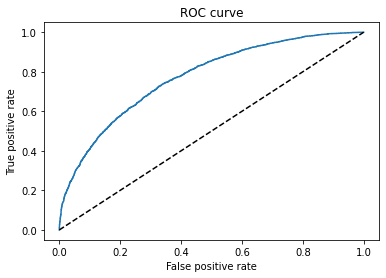

In [ ]:
# fit the algorithm on the whole data
reg.fit(X, y)
# predict the probability of Wins
prob = reg.predict_proba(X)[:, 1]
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y, prob)
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# set the tile and axes labels
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

In [ ]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold: {best_thresh:.4f}')

Best Threshold: 0.4827


In [ ]:
# save the model to disk
pickle.dump(reg, open('/content/drive/My Drive/Finlytics Hub/Data Science/Cricket/Final Model/Final_LR_Model.pkl', 'wb'))